In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import pymc
from pymc import utils
from pymc.database import base
import pygem_input as input

import glob

#plotting functions
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.mlab as mlab
from scipy.stats import gaussian_kde
import scipy.stats as stats
from scipy.stats import truncnorm
from scipy.stats import norm

variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
vn_title_dict = {'massbal':'Mass Balance',                                                                      
                 'precfactor':'Precipitation Factor',                                                              
                 'tempchange':'Temperature Bias',                                                               
                 'ddfsnow':'DDF Snow'}
vn_label_dict = {'massbal':'Mass balance\n[mwea]',                                                                      
                 'precfactor':'Precipitation factor\n[-]',                                                              
                 'tempchange':'Temperature bias\n[degC]',                                                               
                 'ddfsnow':'DDF Snow\n[mwe $degC^{-1} d^{-1}$]'}
metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                     'MC Error': 'Monte Carlo Error',
                     'Effective N': 'Effective Sample Size'}
metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']

suffix = '_trunc'
mcmc_output_netcdf_fp = '../MCMC_data/netcdf' + suffix + '/'
mcmc_output_figures_fp = '../MCMC_data/figures' + suffix + '/'
mcmc_output_tables_fp = '../MCMC_data/tables/'
mcmc_output_csv_fp = '../MCMC_data/csv' + suffix + '/'
mcmc_output_hist_fp = '../MCMC_data/hist' + suffix + '/'

In [27]:
def plot_posterior_comparison(iters=[1000, 15000, 30000], region='all'):
    """
    Compares prior to poster distribution for different chain lengths


    Parameters
    ----------
    iters : list of ints
        list of chain lengths for compare posteriors of
    region : int or 'all'
        RGI glacier region

    Returns
    -------
    .png files
        saves figure showing how prior and posterior comparison
    """

    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
    vn_title_dict = {'massbal':'Mass Balance',
                     'precfactor':'Precipitation Factor',
                     'tempchange':'Temperature Bias',
                     'ddfsnow':'DDF Snow'}
    metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                         'MC Error': 'Monte Carlo Error',
                         'Effective N': 'Effective Sample Size'}
    metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']
    vn_label_dict = {'massbal':'Mass balance [mwea]',
                 'precfactor':'Precipitation factor [-]',
                 'tempchange':'Temperature bias [$^{\circ}C$]',
                 'ddfsnow':'DDF Snow [mwe $^{\circ}C^{-1} d^{-1}$]'}
    csv_path = '../DEMs/Shean_2018_0806/hma_mb_20180803_1229.csv'

    if region == 'all':
        regions = ['13', '14', '15']
        filelist = []
        for reg in regions:
            filelist.extend(glob.glob(mcmc_output_netcdf_fp + str(reg) + '*.nc'))
    else:
        filelist = glob.glob(mcmc_output_netcdf_fp + str(region) + '*.nc')

    filelist = [filelist[2400], filelist[2000]] #2100, 2300 centered

    # hard code font sizes
    ticks=10
    suptitle=14
    title=10
    titley = 1.05
    label=10
    plotline=1.5
    plotline2=1
    legend=10
    figsize=(6.5, 9)
    dpi=100
    hspace=0.5
    wspace=0.3
    sup_y = 0.97
    nrows=4
    ncols=2
    num_stds=1
    alpha = 0.7
    s_alpha = 0.5
    #color = '#006d24'#'#0176cf'
    #colors = ['#d6003d', '#9f7c00', '#5d0087']
    color = 'black'
    colors = ['#387ea0', '#d20048', '#fcb200']

    plt.figure(figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    n_len = len(filelist)
    v_len = len(variables)


    for n_count,netcdf in enumerate(filelist):

        ds = xr.open_dataset(netcdf)

        # create subplot for each variable
        for v_count, vn in enumerate(variables):

            # plot histogram
            ax = plt.subplot(nrows, ncols, n_len*v_count+n_count+1)

            if vn == 'massbal':

                region_no = float(netcdf[-11:-3])
                df_all = pd.read_csv(csv_path)
                mu = df_all[df_all['RGIId'] == region_no]['mb_mwea'].values[0]
                sigma = df_all[df_all['RGIId'] == region_no]['mb_mwea_sigma'].values[0]
                boundlow = mu - 3*sigma
                boundhigh = mu + 3*sigma

            if vn == 'tempchange':

                mu = input.tempchange_mu
                sigma = input.tempchange_sigma
                boundlow = input.tempchange_boundlow
                boundhigh = input.tempchange_boundhigh

            elif vn == 'ddfsnow':

                mu = input.ddfsnow_mu
                sigma = input.ddfsnow_sigma
                boundlow = input.ddfsnow_boundlow
                boundhigh = input.ddfsnow_boundhigh

            elif vn == 'precfactor':

                mu = input.precfactor_mu
                sigma = input.precfactor_sigma
                boundlow = input.precfactor_boundlow
                boundhigh = input.precfactor_boundhigh

            x_range = np.linspace(boundlow,boundhigh,1000)
            if vn == 'massbal':
                a, b = (boundlow - mu) / sigma, (boundhigh - mu) / sigma
                ax.plot(x_range, truncnorm.pdf(x_range, a, b, loc = mu, scale = sigma),
                         color=color, linewidth=plotline, label='Prior')
            else:
                ax.plot(x_range, norm.pdf(x_range, mu, sigma),
                        color=color, linewidth=plotline)

            k = 0
            for i in iters:
                
                for j in range(1):

                    data = ds['mp_value'].sel(chain=j, mp=vn).values[0:i]

                    # plot the actual density distribution
                    density = gaussian_kde(data)
                    density.covariance_factor = lambda : .25
                    density._compute_covariance()
                    if j == 0:
                        ax.plot(x_range,density(x_range), color = colors[k],
                                 linewidth=plotline, label=str(i))
                    else:
                        ax.plot(x_range,density(x_range), color = colors[k],
                                 linewidth=plotline)                        
                k += 1

            # niceties
            if v_count == 0:
                glac_no  = str(region_no)
                plt.title('RGI ' + glac_no[0:2] + '-' + glac_no[3:], fontsize=title, y=titley)

            ylabel = 'Probability density'

            if n_count == 0:
                #ax.set_ylabel(vn_title_dict[vn] + '\n\n' + ylabel, fontsize=label)
            #else:
                ax.set_ylabel(ylabel, fontsize=label)

            ax.set_xlabel(vn_label_dict[vn], fontsize=label)
            
            if vn == 'ddfsnow' and n_count == 0:
                ax.legend(loc='upper left', fontsize=legend)
                
    # Save figure
    #plt.savefig(mcmc_output_figures_fp + 'prior_comparison.png',
     #           bbox_inches='tight')                

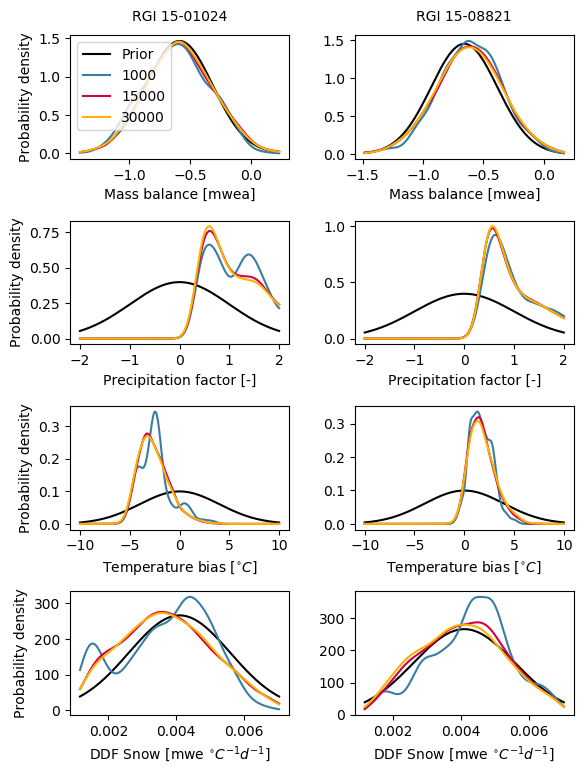

In [28]:
plot_posterior_comparison()

In [39]:
def plot_posterior_comparison_single_glacier(iters=[1000, 15000], region='all'):
    """
    Compares prior to poster distribution for different chain lengths


    Parameters
    ----------
    iters : list of ints
        list of chain lengths for compare posteriors of
    region : int or 'all'
        RGI glacier region

    Returns
    -------
    .png files
        saves figure showing how prior and posterior comparison
    """

    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
    vn_title_dict = {'massbal':'Mass Balance',
                     'precfactor':'Precipitation Factor',
                     'tempchange':'Temperature Bias',
                     'ddfsnow':'DDF Snow'}
    metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                         'MC Error': 'Monte Carlo Error',
                         'Effective N': 'Effective Sample Size'}
    metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']
    vn_label_dict = {'massbal':'Mass balance [mwea]',
                 'precfactor':'Precipitation factor [-]',
                 'tempchange':'Temperature bias [$^{\circ}C$]',
                 'ddfsnow':'DDF Snow [mwe $^{\circ}C^{-1} d^{-1}$]'}
    csv_path = '../DEMs/Shean_2018_0806/hma_mb_20180803_1229.csv'

    if region == 'all':
        regions = ['13', '14', '15']
        filelist = []
        for reg in regions:
            filelist.extend(glob.glob(mcmc_output_netcdf_fp + str(reg) + '*.nc'))
    else:
        filelist = glob.glob(mcmc_output_netcdf_fp + str(region) + '*.nc')

    filelist = [filelist[2400]] #2100, 2300 centered

    # hard code font sizes
    ticks=10
    suptitle=14
    title=10
    titley = 1.05
    label=10
    plotline=1.5
    plotline2=1
    legend=10
    figsize=(6.5, 6)
    dpi=100
    hspace=0.4
    wspace=0.3
    sup_y = 0.97
    nrows=2
    ncols=2
    num_stds=1
    alpha = 0.7
    s_alpha = 0.5
    #color = '#006d24'#'#0176cf'
    #colors = ['#d6003d', '#9f7c00', '#5d0087']
    color = 'black'
    colors = ['#387ea0', '#d20048', '#fcb200']
    linestyles = ['-', '--', ':']

    plt.figure(figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    n_len = len(filelist)
    v_len = len(variables)


    for n_count,netcdf in enumerate(filelist):

        ds = xr.open_dataset(netcdf)

        # create subplot for each variable
        for v_count, vn in enumerate(variables):

            # plot histogram
            ax = plt.subplot(nrows, ncols, v_count+1)

            if vn == 'massbal':

                region_no = float(netcdf[-11:-3])
                df_all = pd.read_csv(csv_path)
                mu = df_all[df_all['RGIId'] == region_no]['mb_mwea'].values[0]
                sigma = df_all[df_all['RGIId'] == region_no]['mb_mwea_sigma'].values[0]
                boundlow = mu - 3*sigma
                boundhigh = mu + 3*sigma

            if vn == 'tempchange':

                mu = input.tempchange_mu
                sigma = input.tempchange_sigma
                boundlow = input.tempchange_boundlow
                boundhigh = input.tempchange_boundhigh

            elif vn == 'ddfsnow':

                mu = input.ddfsnow_mu
                sigma = input.ddfsnow_sigma
                boundlow = input.ddfsnow_boundlow
                boundhigh = input.ddfsnow_boundhigh

            elif vn == 'precfactor':

                mu = input.precfactor_mu
                sigma = input.precfactor_sigma
                boundlow = input.precfactor_boundlow
                boundhigh = input.precfactor_boundhigh

            x_range = np.linspace(boundlow,boundhigh,1000)
            if vn == 'massbal':
                a, b = (boundlow - mu) / sigma, (boundhigh - mu) / sigma
                ax.plot(x_range, truncnorm.pdf(x_range, a, b, loc = mu, scale = sigma),
                         color=color, linewidth=plotline, label='Prior')
            else:
                ax.plot(x_range, norm.pdf(x_range, mu, sigma),
                        color=color, linewidth=plotline, label='Prior')

            k = 0
            for i in iters:
                
                for j in range(3):

                    data = ds['mp_value'].sel(chain=j, mp=vn).values[0:i]

                    # plot the actual density distribution
                    density = gaussian_kde(data)
                    density.covariance_factor = lambda : .25
                    density._compute_covariance()
                    if j == 0:
                        ax.plot(x_range,density(x_range), color = colors[k],
                                 linewidth=plotline, label=str(i), linestyle=linestyles[j])
                    else:
                        ax.plot(x_range,density(x_range), color = colors[k],
                                 linewidth=plotline, linestyle=linestyles[j])                        
                k += 1

            ylabel = 'Probability density'

            if v_count % 2 == 0:
                #ax.set_ylabel(vn_title_dict[vn] + '\n\n' + ylabel, fontsize=label)
            #else:
                ax.set_ylabel(ylabel, fontsize=label)

            ax.set_xlabel(vn_label_dict[vn], fontsize=label)
            
            if vn == 'ddfsnow' and n_count == 0:
                ax.legend(loc='upper right', fontsize=legend,
                          frameon=False, handlelength=1.35,
                          labelspacing=0.3, borderaxespad=0.1,
                          handletextpad=0.5)
                
    # Save figure
    #plt.savefig(mcmc_output_figures_fp + 'prior_comparison.png',
     #           bbox_inches='tight')                

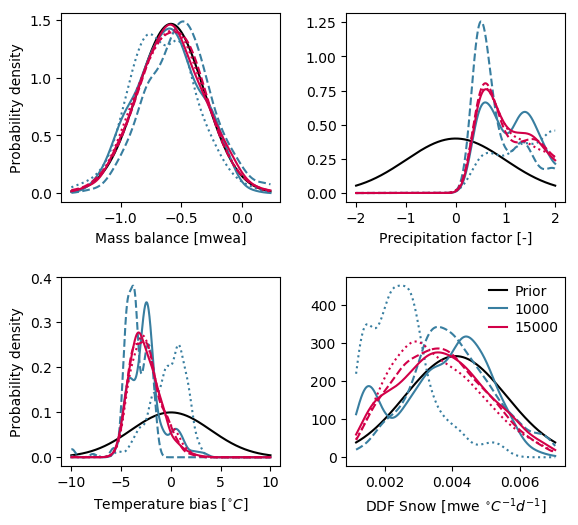

In [40]:
plot_posterior_comparison_single_glacier()